In [1]:
# Setup the library
import pyrogue as pr
import h5py
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

#constants
ACQUIRE_C = True
#STEP OF 1 IS PREFFERED FOR MISSING CODE IDENTIFICATION, INL, DNL
#STEP OF 10 IS PREFFERED FOR DYNAMIC RANGE
SCAN_STEP_C = 10
CONVERT_C = True
ANALYSE_C = False

filename_root = '/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/'




In [2]:
# Create and start the root class
if ACQUIRE_C :
    root = epix_hr_single_10k.RootLCLSIITiming(
        top_level   = top_level,
        dev         = '/dev/datadev_1',
        sim         = False,
        asicVersion = 3
    )
    root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
if ACQUIRE_C :
    AxiVersion = root.Core.AxiVersion
    print ( '###################################################')
    print ( '#             Firmware Version                    #')
    print ( '###################################################')
    AxiVersion.printStatus()
    print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:31:50
GitHash      = 0x91b9a02f0d07162a78f04638906d35cf1ed23caf
XilinxDnaId  = 0x400200010139f5e11ce12205
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Fri 30 Sep 2022 01:25:56 PM PDT
Builder      = ddoering
###################################################


In [4]:
#Initialze the camera
if ACQUIRE_C :
    #[routine, asic0, asic1, asic2, asic3]'
    root.EpixHR.InitASIC([4,0,0,1,0])
    
    #points to the ASIC device under test
    ASIC = root.EpixHR.Hr10kTAsic2
   

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.Epi

Helper Functions

In [5]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kT'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

def getData(localFile):

    file_header = [0]
    numberOfFrames = 0
    previousSize = 0
    while ((len(file_header)>0) and ((numberOfFrames<MAX_NUMBER_OF_FRAMES_PER_BATCH) or (MAX_NUMBER_OF_FRAMES_PER_BATCH==-1))):
        try:
            # reads file header [the number of bytes to read, EVIO]
            file_header = np.fromfile(localFile, dtype='uint32', count=2)
            payloadSize = int(file_header[0]/2)-2 #-1 is need because size info includes the second word from the header
            newPayload = np.fromfile(f, dtype='uint16', count=payloadSize) #(frame size splited by four to read 32 bit 
            #save only serial data frames
            if (numberOfFrames == 0):
                allFrames = [newPayload.copy()]
            else:
                newFrame  = [newPayload.copy()]
                allFrames = np.append(allFrames, newFrame, axis = 0)
            numberOfFrames = numberOfFrames + 1 
            #print ("Payload" , numberOfFrames, ":",  (newPayload[0:5]))
            previousSize = file_header
       
            if (numberOfFrames%1000==0):
                print("Read %d frames" % numberOfFrames)

        except Exception: 
            e = sys.exc_info()[0]
            #print ("Message\n", e)
            print ('\r', 'numberOfFrames read:', numberOfFrames, 'Size Error, currnt size', file_header, 'previous size', previousSize)
            

    return allFrames

def getDescImaData(localAllFrames):
##################################################
# image descrambling
##################################################
    numberOfFrames = localAllFrames.shape[0]
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
#numberOfFrames = allFrames.shape[0]
    print("numberOfFrames in the 3D array: " ,numberOfFrames)
    print("Starting descrambling images")
    currentRawData = []
    imgDesc = []
    if(numberOfFrames==1):
        [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData = [], newRawData = allFrames[0])
        imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
    else:
        for i in range(0, numberOfFrames):
        #get an specific frame
            [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData, newRawData = localAllFrames[i,:])
            currentRawData = rawImgFrame

        #get descrambled image from camera
            if (len(imgDesc)==0 and (readyForDisplay)):
                imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                currentRawData = []
            else:
                if readyForDisplay:
                    currentRawData = []
                    newImage = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                #newImage = currentCam.descrambleImage(rawImgFrame)
                #newImage = newImage.astype(np.float, copy=False)
                #if (np.sum(np.sum(newImage))==0):
                #    newImage[np.where(newImage==0)]=np.nan
                    imgDesc = np.concatenate((imgDesc, np.array([newImage[0]])),0)

    return imgDesc

def printname(name):
    print (name)

def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())
    
def setADC (RefGenB = 3, RefGenC = 2, S2D_1_b = 0, shvc_DAC = 23, S2dDacBias = 3):
    print('Original values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())
    
    ASIC.RefGenB.set(RefGenB) #2 bits
    ASIC.RefGenC.set(RefGenC) #2 bits
    ASIC.S2D_1_b.set(S2D_1_b) #3 bits
    ASIC.shvc_DAC.set(shvc_DAC) #6 bits
    ASIC.S2dDacBias.set(S2dDacBias)
    
    print('New values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())
    
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def runDataAquistion(filename):
    #sets ASIC to point to the external DAC
    ASIC.mTest.set(True)
     #Makes sure triggers are off
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    time.sleep(10)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    #use system with batcher and missing ASICs
    root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
    print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
    
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)

    #sets HSDAC device
    root.EpixHR.HSDac.enable.set(True)
    #reset status
    root.EpixHR.HSDac.WFEnabled.set(False)
    root.EpixHR.HSDac.waveformSource.set(0)
    root.EpixHR.HSDac.externalUpdateEn.set(False)
    root.EpixHR.HSDac.run.set(False)

    #configure
    root.EpixHR.HSDac.rCStartValue.set(0)
    root.EpixHR.HSDac.rCStopValue.set(65535)
    root.EpixHR.HSDac.rCStep.set(SCAN_STEP_C)
    root.EpixHR.HSDac.WFEnabled.set(True)
    root.EpixHR.HSDac.waveformSource.set(1)
    root.EpixHR.HSDac.externalUpdateEn.set(True)
    root.EpixHR.HSDac.run.set(True)

    # Remove previous dataset
    #if os.path.isfile(f'{top_level}/test.dat'):
    #    os.remove(f'{top_level}/test.dat')    
    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    


    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(100000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()

    # Wait for the file write to write the 10 waveforms
    while(writer.getFrameCount() < int(65535/SCAN_STEP_C)):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

        
def convertData(filename):
    from importlib import reload
    reload(cameras)
    
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    
    if os.path.isfile(f'{h5_filename}'):
        os.remove(f'{h5_filename}')    

    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
    currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH

    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(round(66/SCAN_STEP_C)):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    #numberOfFrames = allFrames.shape[0]
    print("Saving Hdf5")       
    f = h5py.File(h5_filename, "w")
    for i in range(0,6):
        f['header_%d'%i] = headers[:,i]
    f['adcData'] = imgDesc.astype('uint16')
    f.close()



Camera  ePixHr10kT  selected.


In [13]:
#Makes sure triggers are off
if ACQUIRE_C :
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    time.sleep(10)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)


In [16]:
#use system with batcher and missing ASICs
if ACQUIRE_C :
    root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
    print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
    #Only ASIC 1 is available so disable the 6 lower lanes
    root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
    root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
    #using internal triggers, so bypassing timing channel at the batcher 
    root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
    root.EpixHR.BatcherEventBuilder1.Bypass.set(1)

Locked lanes: 3f000


In [8]:
print('Preamp', ASIC.Preamp.get())
print('Vld1_b',ASIC.Vld1_b.get())
print('Pixel_CB',ASIC.Pixel_CB.get())
print('Filter_DAC',ASIC.Filter_DAC.get())
print('VRef_DAC',ASIC.VRef_DAC.get())

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53


In [9]:
ASIC.DHg.get()
#True, gain of 1.5; False gain of 1.1

True

In [23]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenBList = [0,1,2,3]
    RefGenC = 2
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBias = 3
    for RefGenB in RefGenBList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_All_run1.dat' % RefGenB)
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 0
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 0
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_0_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 2995136
Number of frames received: 5004
Number of frames received: 6005
Delta Aquisition Counter: 7007
Number of frames received: 7007
Original values
RefGenB 0
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_1_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 3012151
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7005
Number of frames received: 7005
Original values
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 2
R

In [31]:
if CONVERT_C :
    for RefGenB in RefGenBList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_All_run1.dat' % RefGenB)
        print(filename)
        ########################################################################################################################         
        convertData(filename)

/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_0_All_run1.dat
Camera  ePixHr10kTBatcher  selected.
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 3
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 4
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 5
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 6
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Saving Hdf5
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3

In [17]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenCList = [0,1,2,3]
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBias = 3
    for RefGenC in RefGenCList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 0
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 0
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_0_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Locked lanes: 3b000
Aquisition Counter 246430
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7006
Number of frames received: 7006
Original values
RefGenB 3
RefGenC 0
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 1
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_1_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 263444
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7006
Number of frames received: 7006
Origi

In [18]:
if CONVERT_C :
    for RefGenC in RefGenCList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_0_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Camera  ePixHr10kTBatcher  selected.
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 3
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 4
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 5
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 6
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Saving Hdf5
/u2/ddoering/A

In [20]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_bList = [0,1,2,3,4,5,6,7]
    shvc_DAC = 23
    S2dDacBias = 3
    for S2D_1_b in S2D_1_bList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for S2D_1_b in S2D_1_bList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 3
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 314483
Number of frames received: 5004
Number of frames received: 6005
Delta Aquisition Counter: 7007
Number of frames received: 7007
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 1
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_1_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 331494
Number of frames received: 5004
Number of frames received: 6006
Delta Aquisition Counter: 7007
Number of frames received: 7007
Origi

TypeError: 'int' object is not iterable

In [21]:
 for S2D_1_b in S2D_1_bList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Camera  ePixHr10kTBatcher  selected.
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 3
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 4
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 5
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 6
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Saving Hdf5
/u2/ddoering/A

In [22]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DACList = [20,21,22,23,24,25,26,27]
    S2dDacBias = 3
    for shvc_DAC in shvc_DACList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for shvc_DAC in shvc_DACList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 2
S2D_1_b 7
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 20
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_20_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 450588
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7006
Number of frames received: 7006
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 20
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 21
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_21_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 467602
Number of frames received: 5003
Number of frames received: 6005
Delta Aquisition Counter: 7006
Number of frames received: 7006
Origi

In [25]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DACList = [28,29,30,31,32,33,34,35]
    S2dDacBias = 3
    for shvc_DAC in shvc_DACList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for shvc_DAC in shvc_DACList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 0
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 28
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_28_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1057136
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7006
Number of frames received: 7006
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 28
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 29
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_29_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1074150
Number of frames received: 5002
Number of frames received: 6003
Delta Aquisition Counter: 7004
Number of frames received: 7004
Ori

In [27]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DACList = [36,37,38,39,40,41,42,43]
    S2dDacBias = 3
    for shvc_DAC in shvc_DACList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for shvc_DAC in shvc_DACList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 43
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 36
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_36_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1329346
Number of frames received: 5003
Number of frames received: 6005
Delta Aquisition Counter: 7006
Number of frames received: 7006
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 36
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 37
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_37_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1346360
Number of frames received: 5004
Number of frames received: 6005
Delta Aquisition Counter: 7007
Number of frames received: 7007
Ori

In [28]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DACList = [44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]
    S2dDacBias = 3
    for shvc_DAC in shvc_DACList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for shvc_DAC in shvc_DACList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 43
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 44
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_44_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1465449
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7005
Number of frames received: 7005
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 44
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 45
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_45_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1482462
Number of frames received: 5004
Number of frames received: 6005
Delta Aquisition Counter: 7007
Number of frames received: 7007
Ori

In [24]:
if ACQUIRE_C :
    #Defaut settings
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.DHg.set(False)
    
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBiasList = [3,2,1,0]
    for S2dDacBias in S2dDacBiasList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)
    
    for S2dDacBias in S2dDacBiasList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 0
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 989085
Number of frames received: 5004
Number of frames received: 6005
Delta Aquisition Counter: 7006
Number of frames received: 7006
Original values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 3
New values
RefGenB 3
RefGenC 2
S2D_1_b 0
shvc_DAC 23
S2dDacBias 2
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_RefGenC_2_S2D_1_b_0_shvc_DAC_23_S2dDacBias_2_All_run1.dat
Locked lanes: 3f000
Aquisition Counter 1006099
Number of frames received: 5001
Number of frames received: 6002
Delta Aquisition Counter: 7003
Number of frames received: 7003
Orig

In [ ]:
if ACQUIRE_C :
    #Defaut settings
    RefGenB = 3
    RefGenCList = [0,1,2,3]
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBias = 3
    for RefGenC in RefGenCList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'RefGenC_%d_All_run1.dat' % RefGenC)
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)

In [ ]:
if ACQUIRE_C :
    #Defaut settings
    RefGenB = 3
    RefGenC = 2
    S2D_1_bList = [0,1,2,3,5,6,7]
    shvc_DAC = 23
    S2dDacBias = 3
    for S2D_1_b in S2D_1_bList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'S2D_1_b_%d_All_run1.dat' % S2D_1_b)
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)

In [ ]:
if ACQUIRE_C :
    #Defaut settings
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DACList = [3,13,18,20,23,25,27,33,43,53,63]
    S2dDacBias = 3
    for shvc_DAC in shvc_DACList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'shvc_DAC_%d_All_run1.dat' % shvc_DAC)
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)

In [ ]:
if ACQUIRE_C :
    #Defaut settings
    RefGenB = 3
    RefGenC = 2
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBiasList = [0,1,2,3,5,6,7]
    for S2dDacBias in S2dDacBiasList:
        setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'S2dDacBias_%d_All_run1.dat' % S2dDacBias)
        print(filename)
        ######################################################################################################################## 
        runDataAquistion(filename)

In [14]:
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_3_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_2_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_1_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_0_All_run1.dat'
#
filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenC_3_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenC_2_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenC_1_All_run1.dat'
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenC_0_All_run1.dat'
#
#filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_S2dDacBias_0_All_run1.dat'
#
filename = '/u2/ddoering/ASIC_V3_ASIC2_SB_SET_ADC_0/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_1_All_run1.dat'
###
#Next, 
#add function to save plot to file using plt
#add distogram, calculate mean and std to the parameters being analysed 
#see if there is an automatic way to define optimal ADC settings.

h5_filename = os.path.splitext(filename)[0]+".hdf5"


if CONVERT_C :
    from importlib import reload
    reload(cameras)
    
    if os.path.isfile(f'{h5_filename}'):
        os.remove(f'{h5_filename}')    

    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
    currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH

    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(round(66/SCAN_STEP_C)):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    #numberOfFrames = allFrames.shape[0]
    SAVEHDF5 = True
    if(SAVEHDF5):
        print("Saving Hdf5")       
        f = h5py.File(h5_filename, "w")
        for i in range(0,6):
            f['header_%d'%i] = headers[:,i]
        f['adcData'] = imgDesc.astype('uint16')
        f.close()



adcData
header_0
header_1
header_2
header_3
header_4
header_5
(7000, 144, 384)


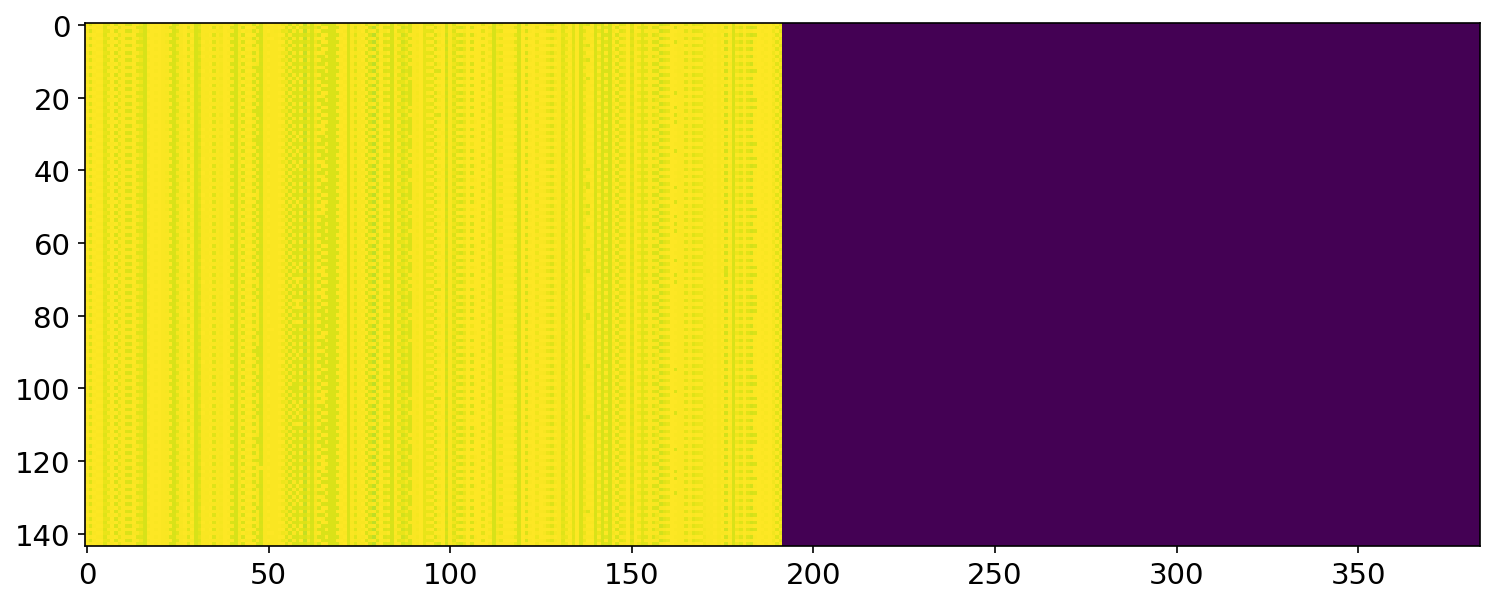

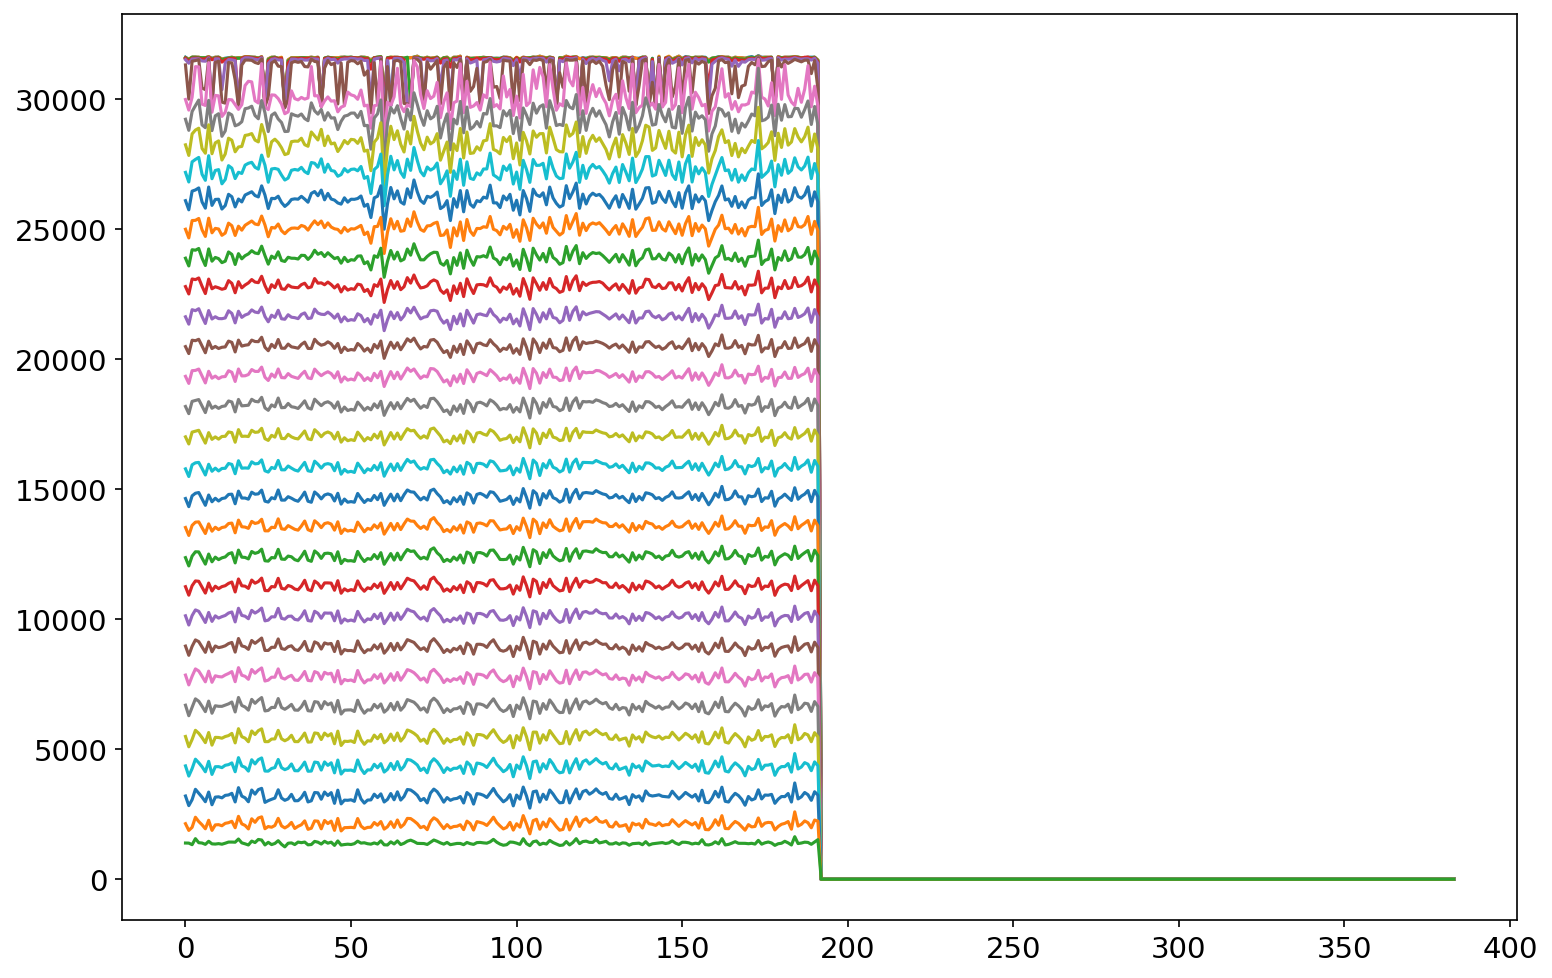

In [15]:
if ANALYSE_C:
    dfile = h5py.File(h5_filename, 'r')
    dfile.visit(printname)
    
    imgDesc = dfile['/adcData']
    
    #for i in range(0,6):
    #    headers[:,i] = dfile['header_%d'%i]
    
    
    print(imgDesc.shape)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(imgDesc[1000])
    plt.figure(2,figsize=(12,8),dpi=150)
    maxRange = imgDesc.shape[0] if (imgDesc.shape[0] < int(65000/SCAN_STEP_C))  else int(65000/SCAN_STEP_C)
    for imgIdx in np.arange(0, maxRange,int(2000/SCAN_STEP_C )):
        plt.plot(imgDesc[imgIdx,20,:])

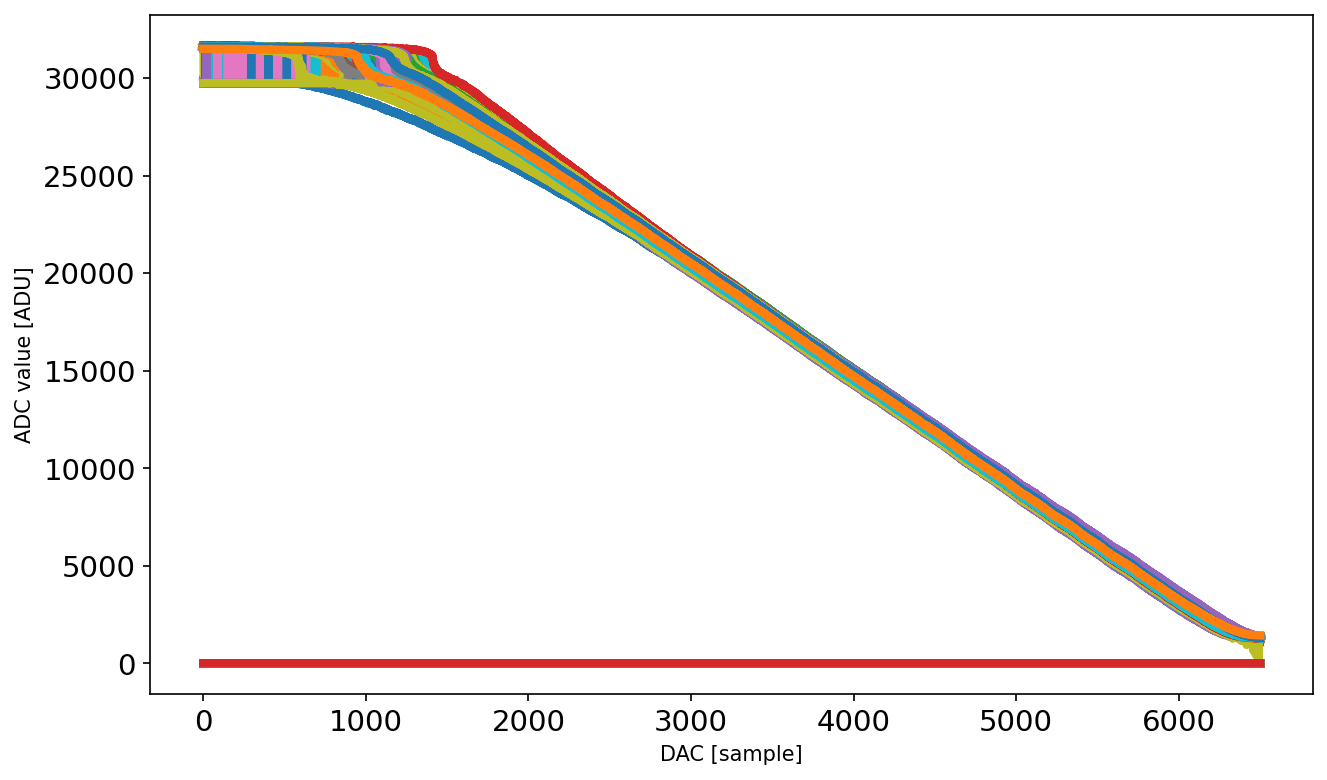

In [16]:
if ANALYSE_C:
    plt.figure(1,figsize=(10,6),dpi=150)
    for column in np.arange(384):
        plt.plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.show()

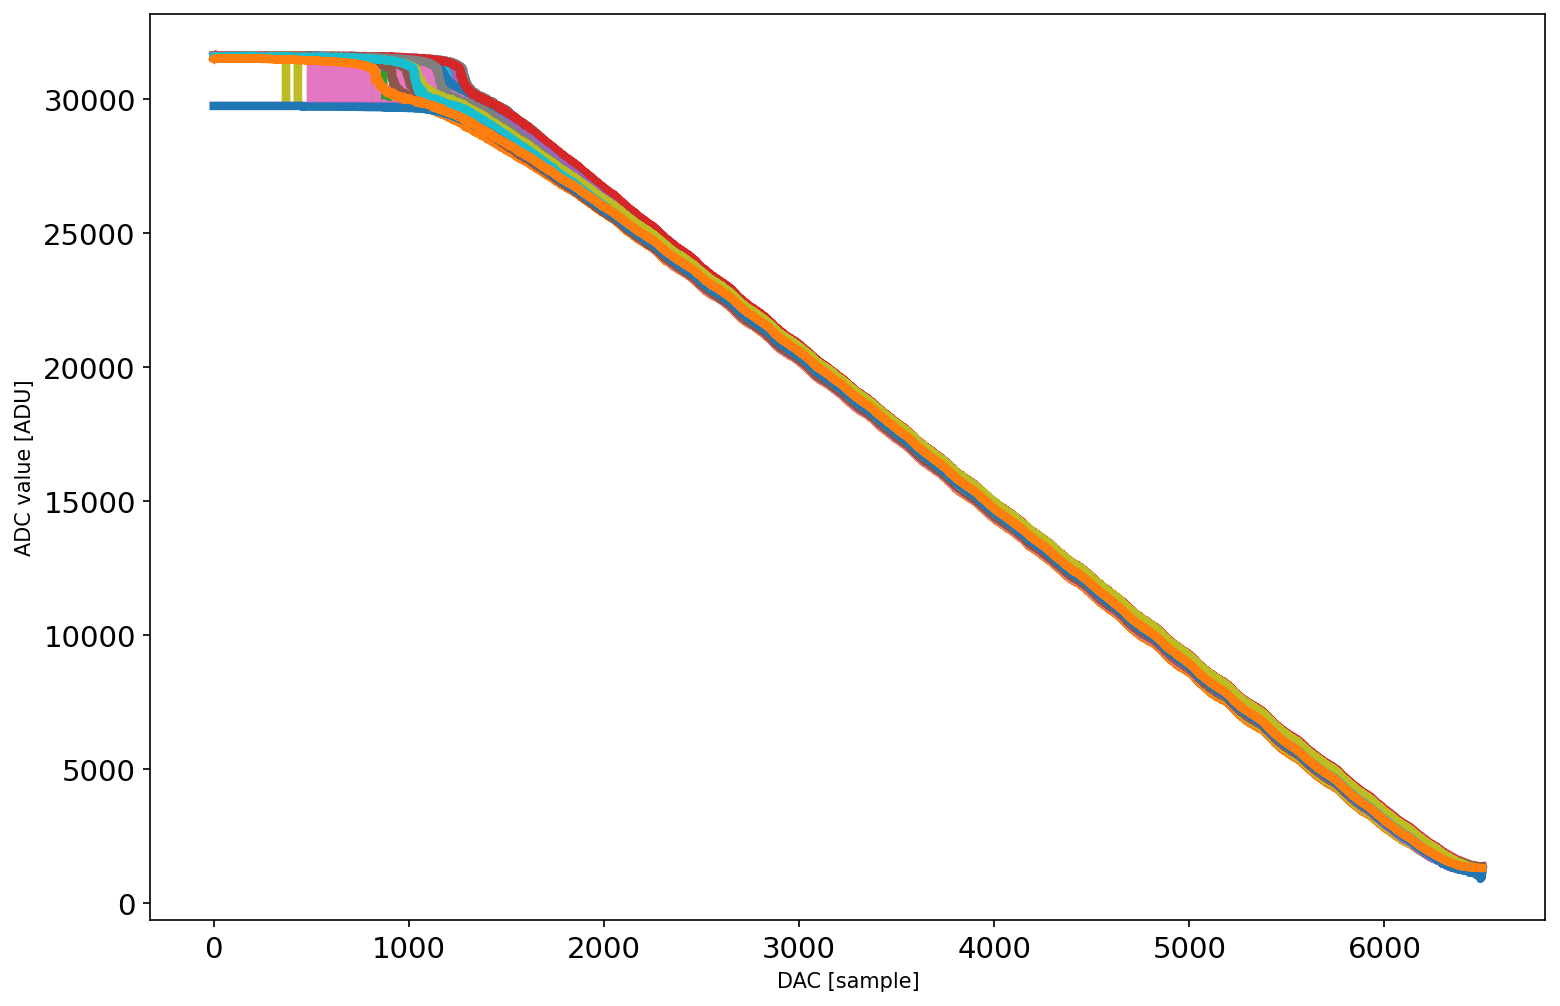

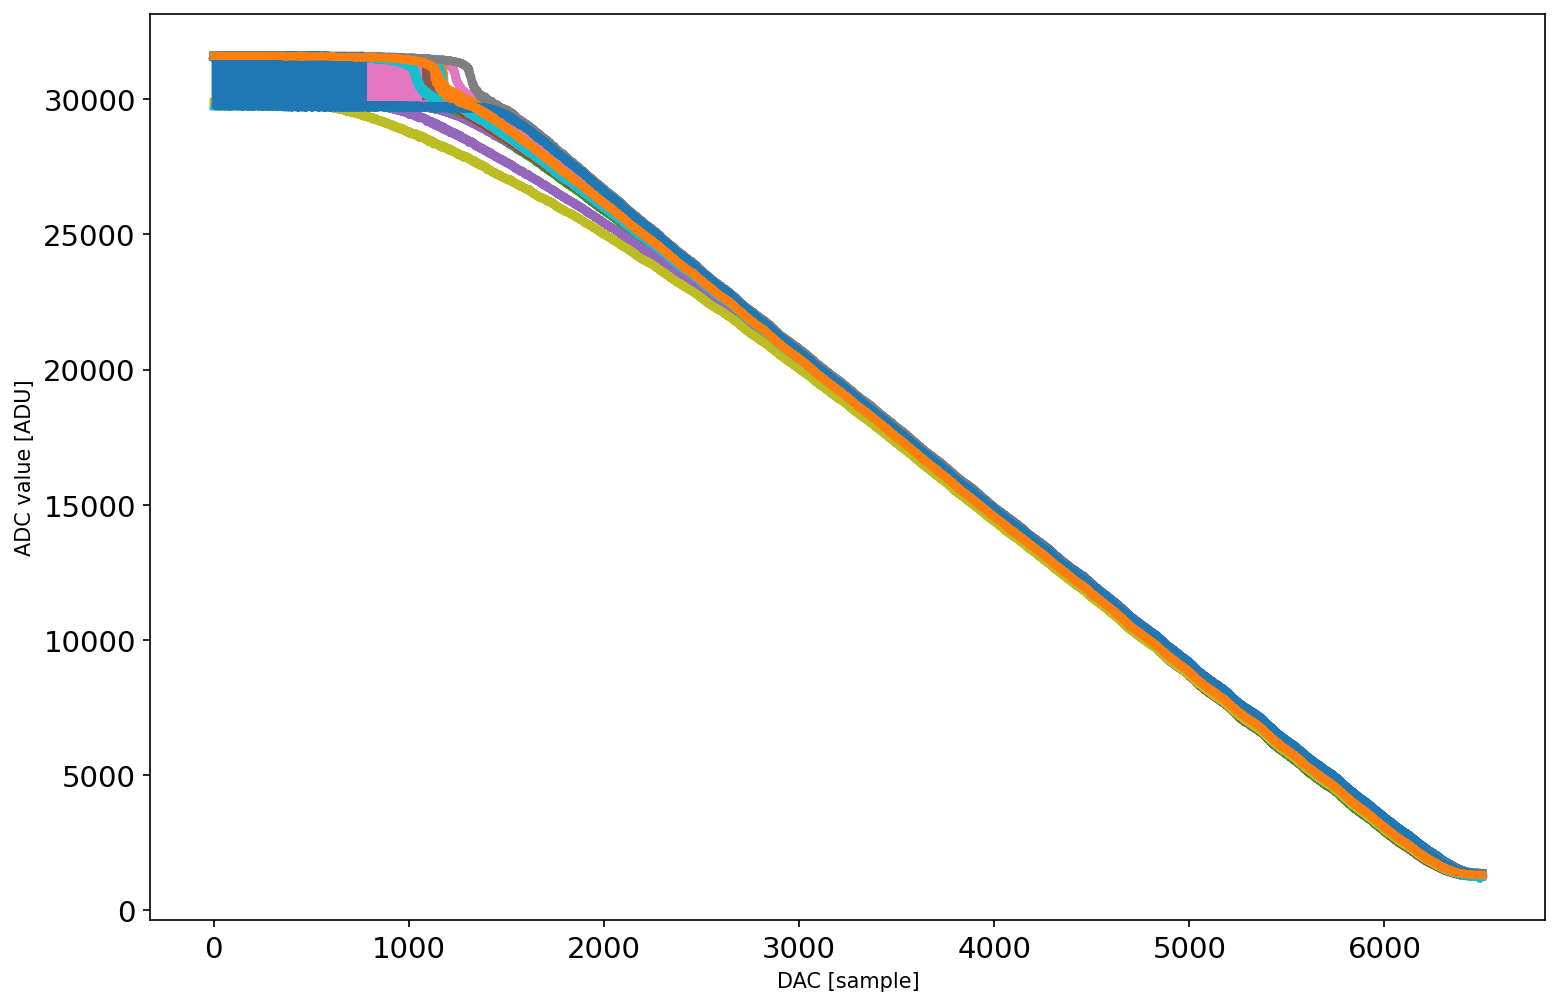

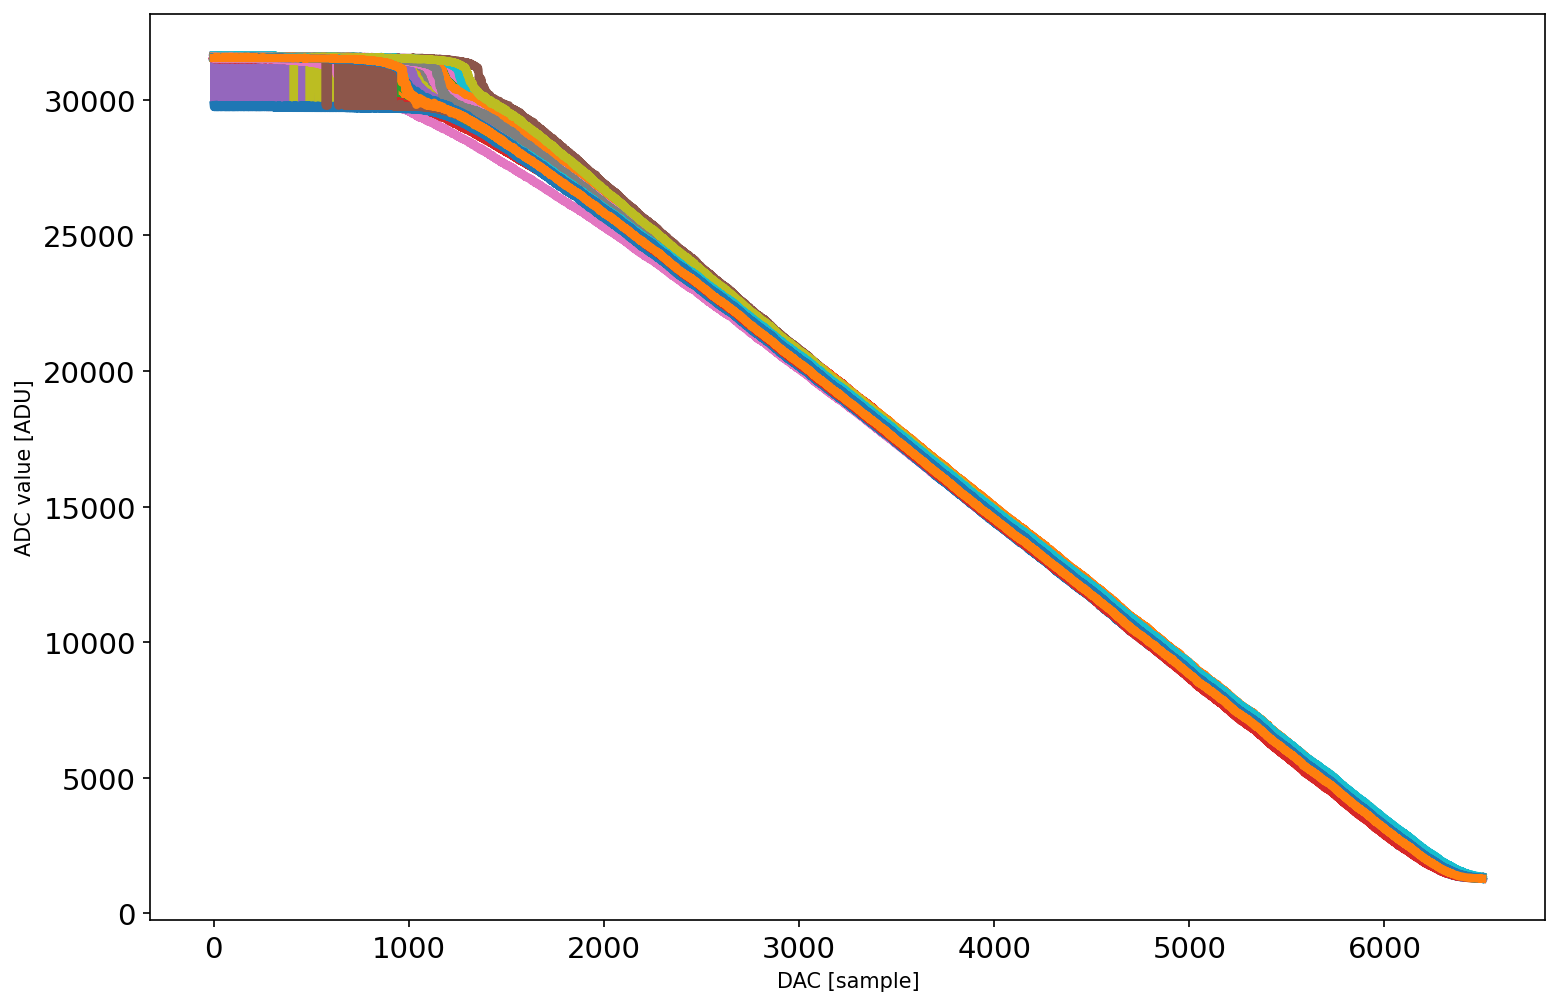

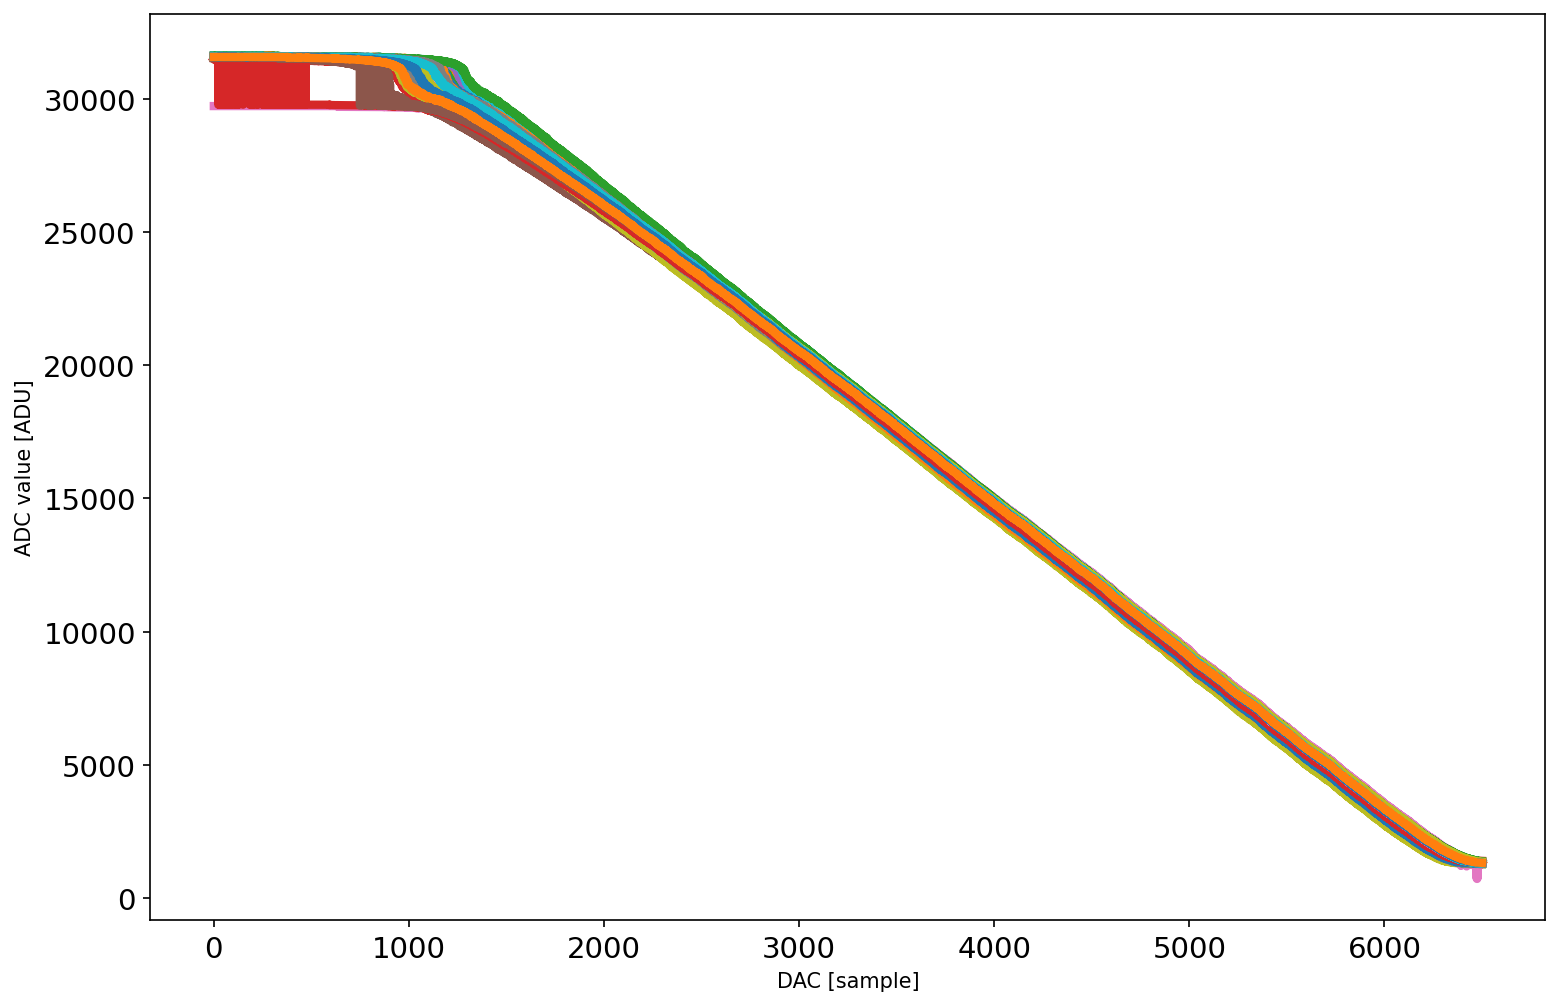

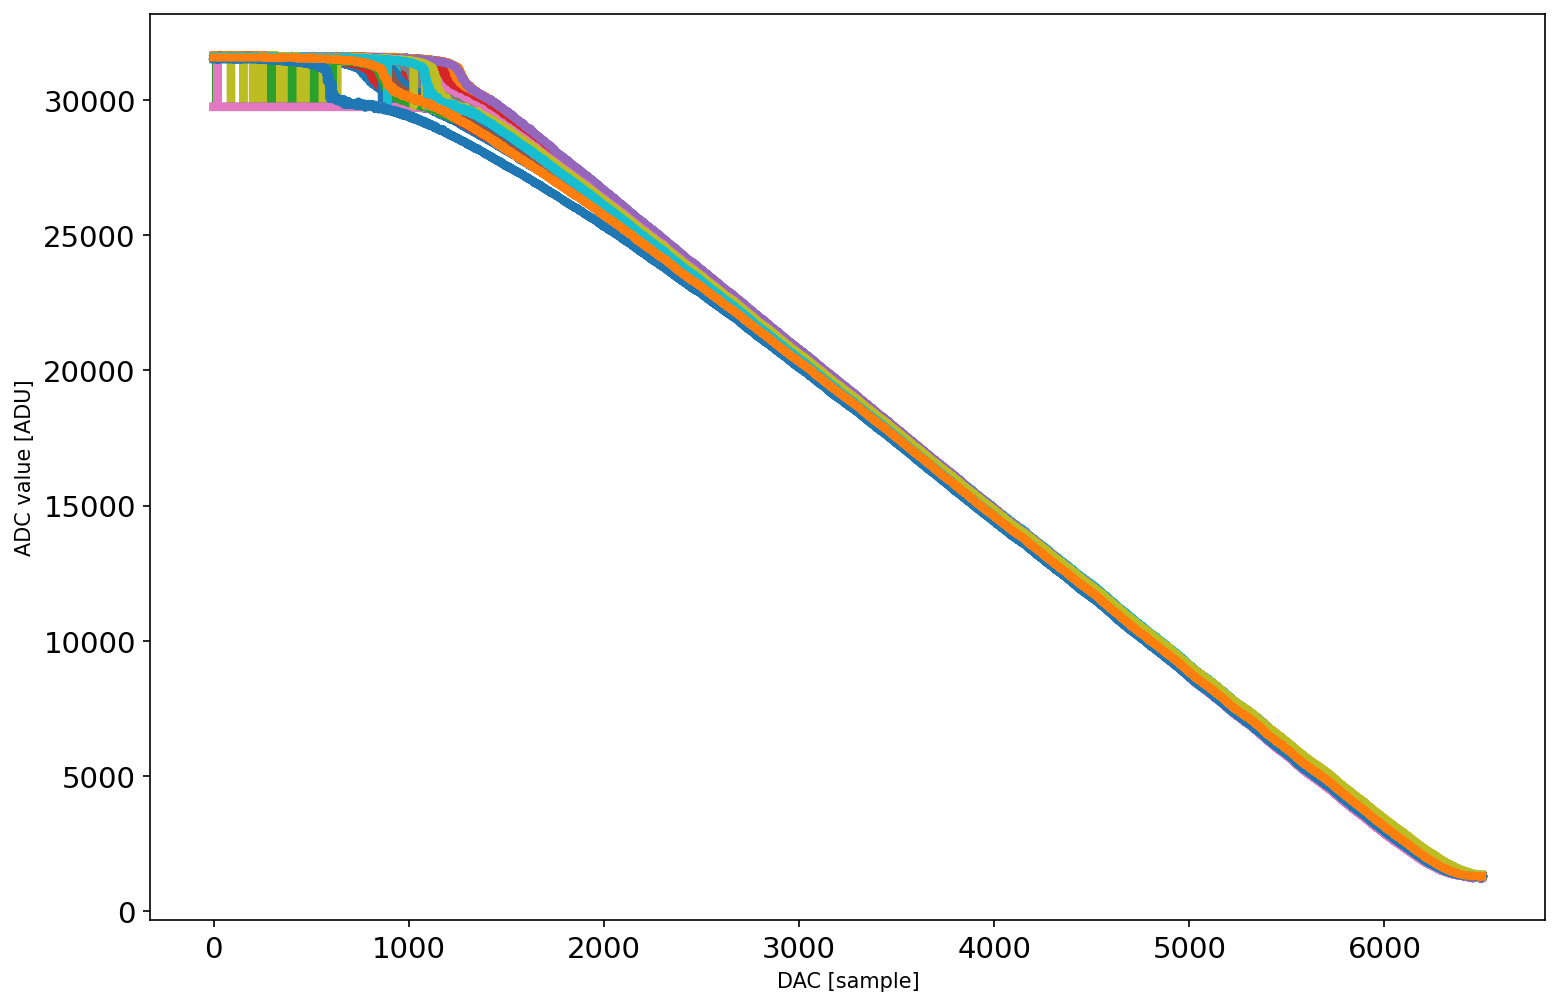

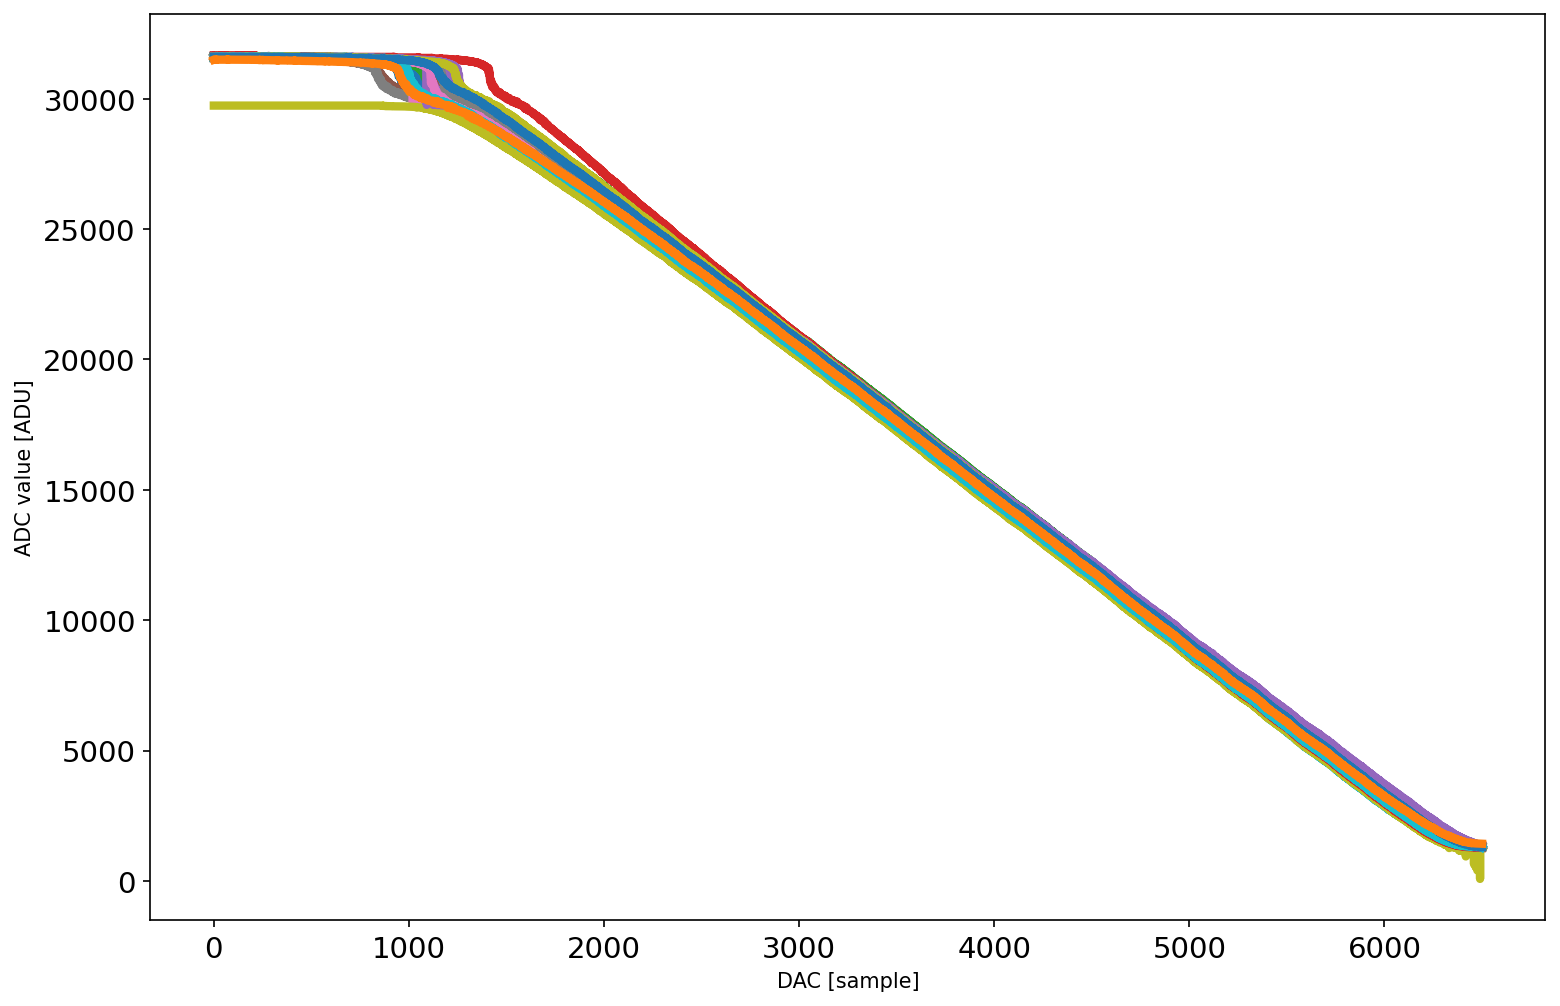

In [17]:
if ANALYSE_C:
    for startCol in np.arange(192*0,192+192*0,32):
        plt.figure(1,figsize=(12,8),dpi=150)
        for column in np.arange(startCol,startCol+32):
            plt.plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
        plt.xlabel('DAC [sample]')
        plt.ylabel('ADC value [ADU]')
        plt.show()


(5000,)
Fitting parameters for ADC Channel [64]
 
-0.1733 x + 5078


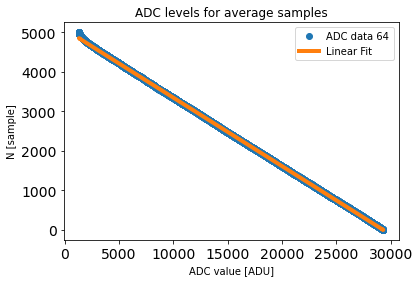

limits are [28183, 1818]


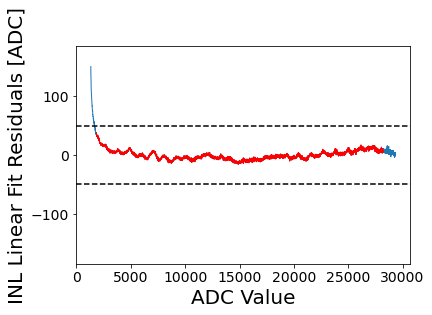

MeasuredMadDevLinFit 37.364774498892984
(5000,)
Fitting parameters for ADC Channel [65]
 
-0.1739 x + 5036


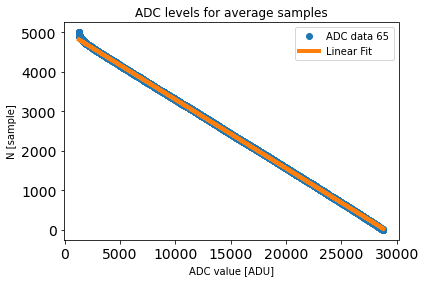

limits are [27717, 1588]


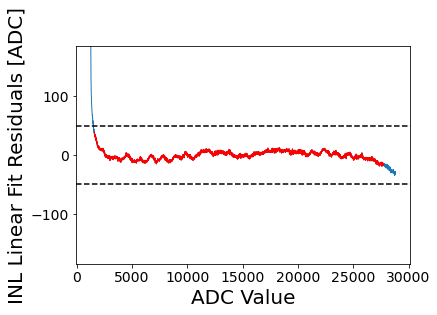

MeasuredMadDevLinFit 39.46736457787483
(5000,)
Fitting parameters for ADC Channel [66]
 
-0.175 x + 5077


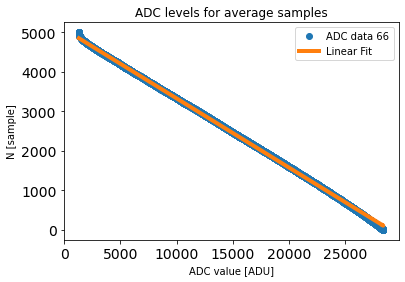

limits are [27466, 1669]


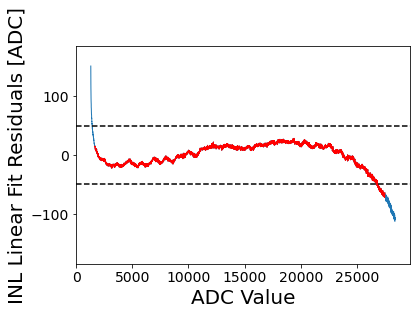

MeasuredMadDevLinFit 71.8770802450963
(5000,)
Fitting parameters for ADC Channel [67]
 
-0.1731 x + 5098


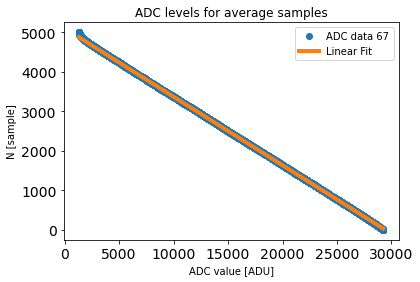

limits are [28220, 1836]


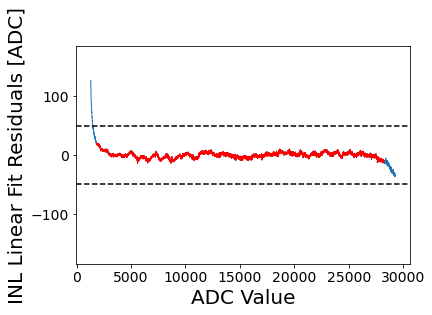

MeasuredMadDevLinFit 20.153062268133908
(5000,)
Fitting parameters for ADC Channel [68]
 
-0.1754 x + 5110


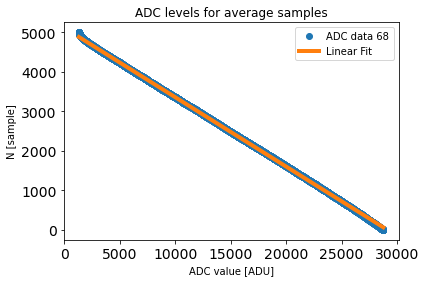

limits are [27760, 1859]


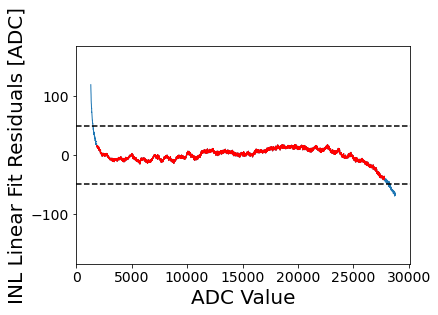

MeasuredMadDevLinFit 42.0642275775499
(5000,)
Fitting parameters for ADC Channel [69]
 
-0.1702 x + 5055


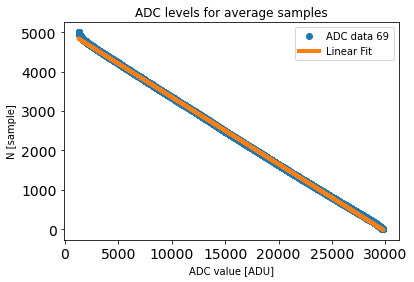

limits are [28777, 1781]


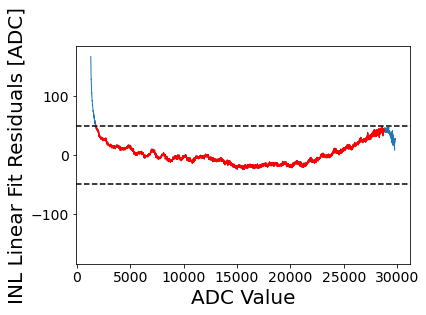

MeasuredMadDevLinFit 48.73127041742919
(5000,)
Fitting parameters for ADC Channel [70]
 
-0.1724 x + 5051


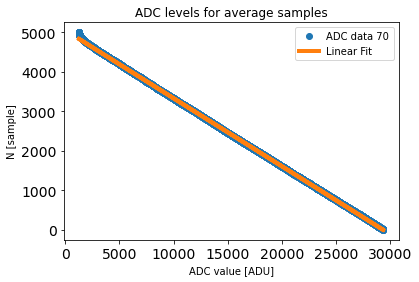

limits are [28188, 1681]


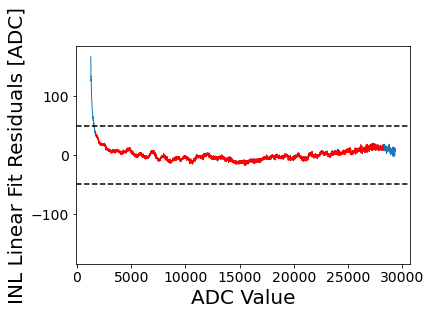

MeasuredMadDevLinFit 38.12269440053569
(5000,)
Fitting parameters for ADC Channel [71]
 
-0.1734 x + 5033


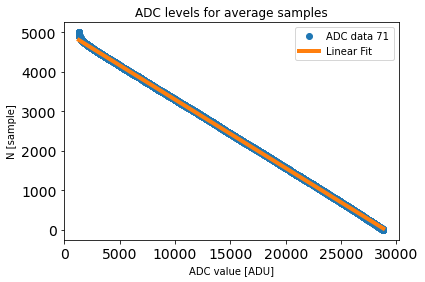

limits are [27752, 1589]


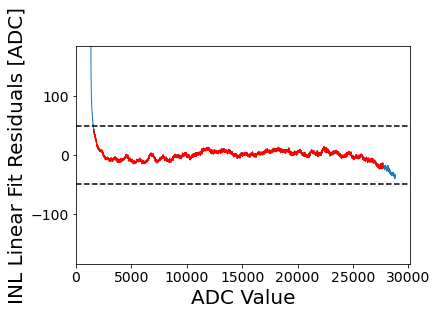

MeasuredMadDevLinFit 43.80899583578139
(5000,)
Fitting parameters for ADC Channel [72]
 
-0.1744 x + 5056


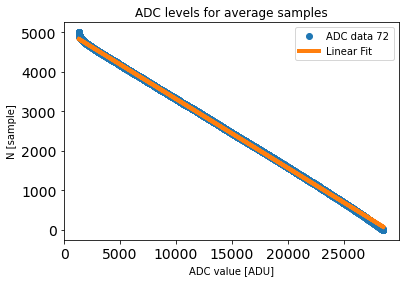

limits are [27550, 1624]


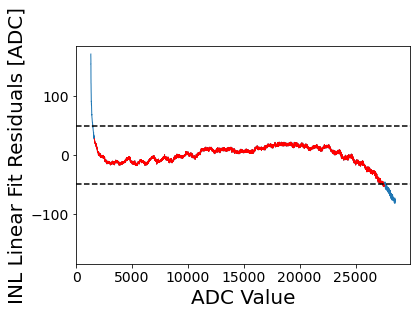

MeasuredMadDevLinFit 53.64525464418057
(5000,)
Fitting parameters for ADC Channel [73]
 
-0.1716 x + 5009


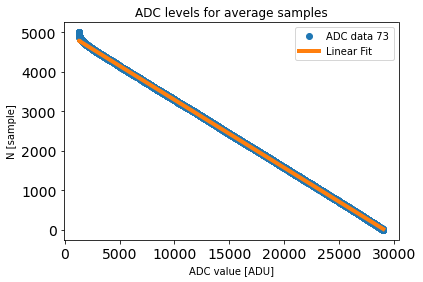

limits are [27947, 1532]


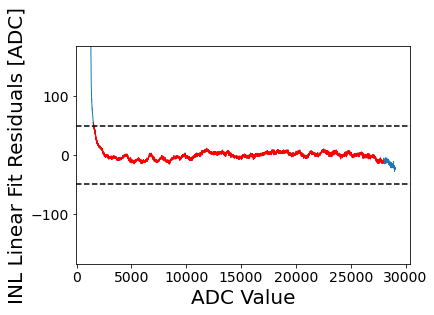

MeasuredMadDevLinFit 54.27609672449671
(5000,)
Fitting parameters for ADC Channel [74]
 
-0.1743 x + 5096


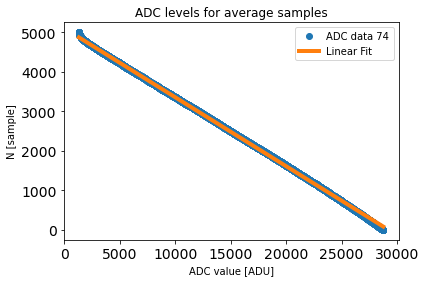

limits are [27758, 1755]


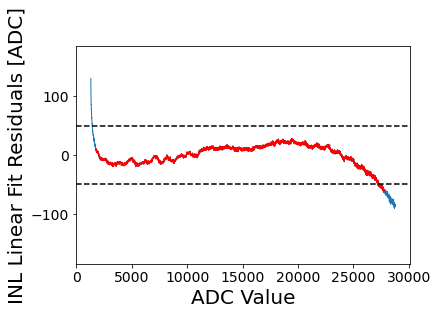

MeasuredMadDevLinFit 62.66370648466818
(5000,)
Fitting parameters for ADC Channel [75]
 
-0.1749 x + 5120


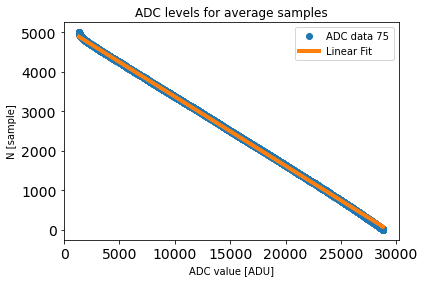

limits are [27874, 1873]


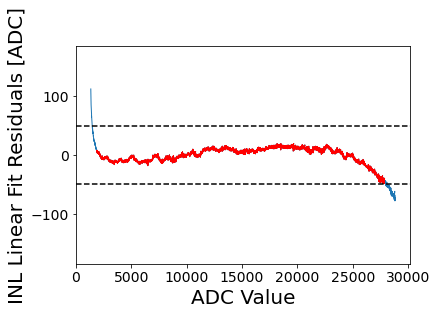

MeasuredMadDevLinFit 48.437830887800374
(5000,)
Fitting parameters for ADC Channel [76]
 
-0.1736 x + 5084


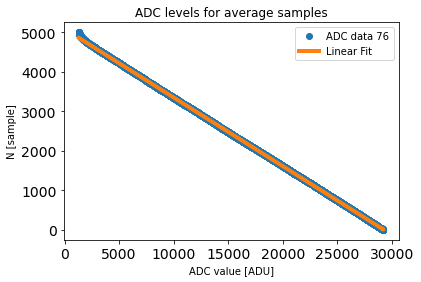

limits are [28103, 1797]


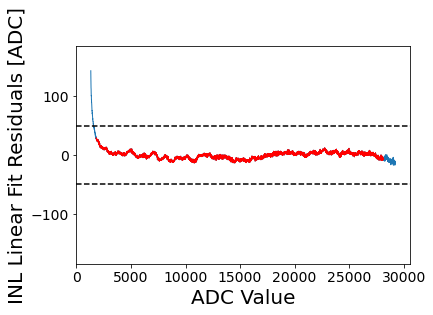

MeasuredMadDevLinFit 29.27145824071431
(5000,)
Fitting parameters for ADC Channel [77]
 
-0.1764 x + 5082


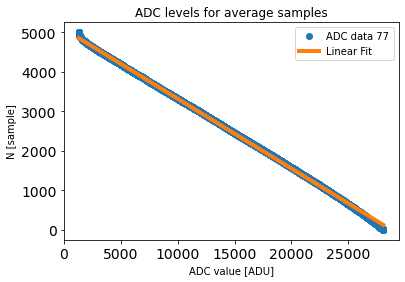

limits are [27207, 1672]


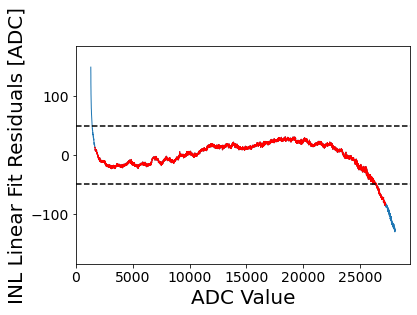

MeasuredMadDevLinFit 85.88899288287394
(5000,)
Fitting parameters for ADC Channel [78]
 
-0.1747 x + 5028


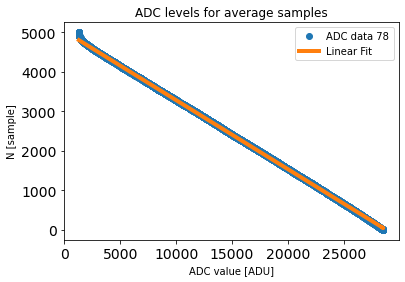

limits are [27453, 1562]


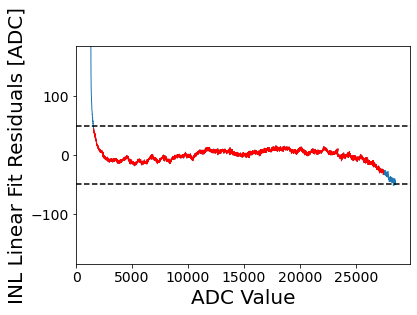

MeasuredMadDevLinFit 44.94537830572517
(5000,)
Fitting parameters for ADC Channel [79]
 
-0.1744 x + 5048


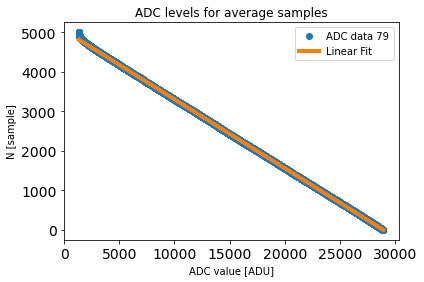

limits are [27788, 1686]


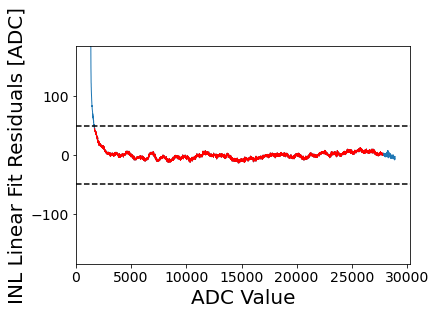

MeasuredMadDevLinFit 45.646056121429865
(5000,)
Fitting parameters for ADC Channel [80]
 
-0.179 x + 5068


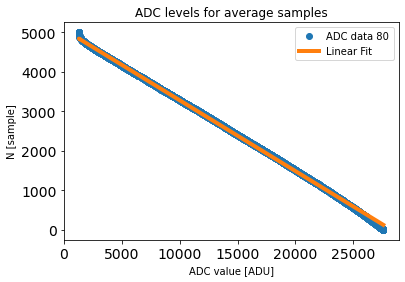

limits are [26711, 1560]


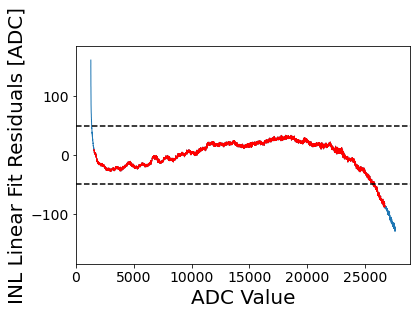

MeasuredMadDevLinFit 88.41369196397864
(5000,)
Fitting parameters for ADC Channel [81]
 
-0.1733 x + 5044


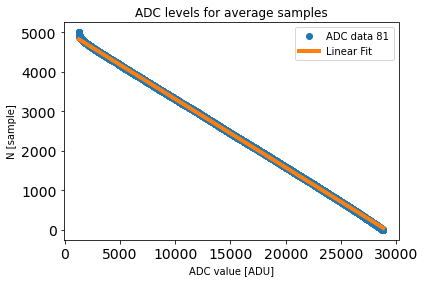

limits are [27776, 1606]


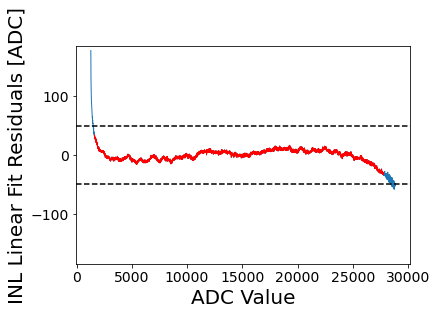

MeasuredMadDevLinFit 34.43510489289747
(5000,)
Fitting parameters for ADC Channel [82]
 
-0.176 x + 5056


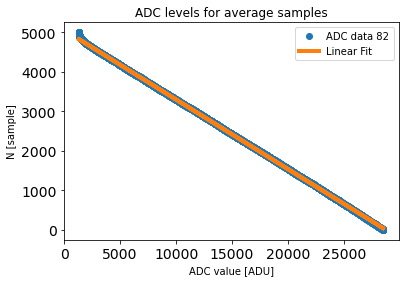

limits are [27432, 1628]


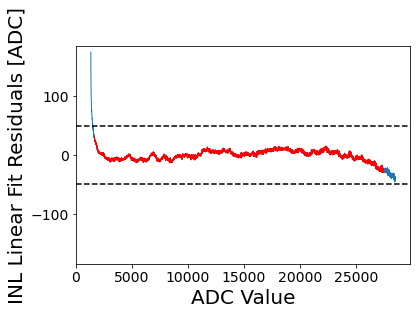

MeasuredMadDevLinFit 30.499218236905108
(5000,)
Fitting parameters for ADC Channel [83]
 
-0.1721 x + 5045


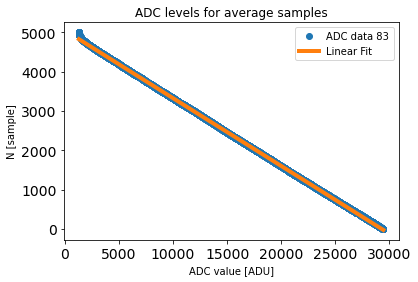

limits are [28294, 1656]


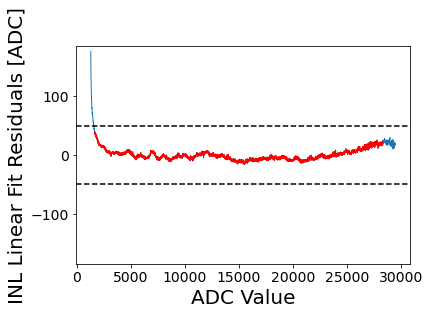

MeasuredMadDevLinFit 39.25031049671634
(5000,)
Fitting parameters for ADC Channel [84]
 
-0.1758 x + 5030


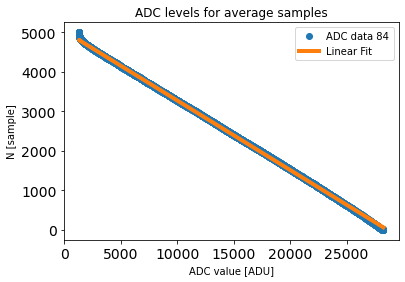

limits are [27202, 1520]


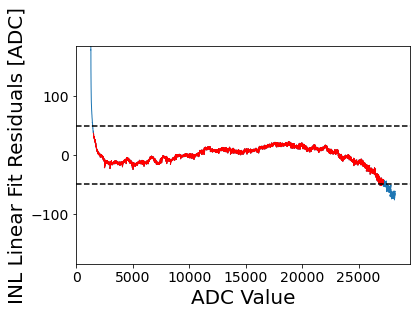

MeasuredMadDevLinFit 51.877163463127545
(5000,)
Fitting parameters for ADC Channel [85]
 
-0.1727 x + 5076


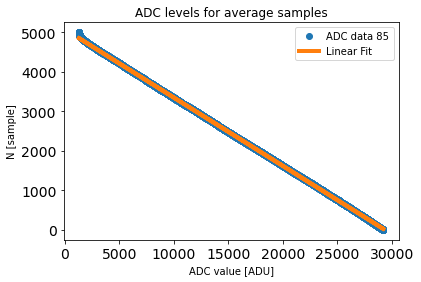

limits are [28144, 1746]


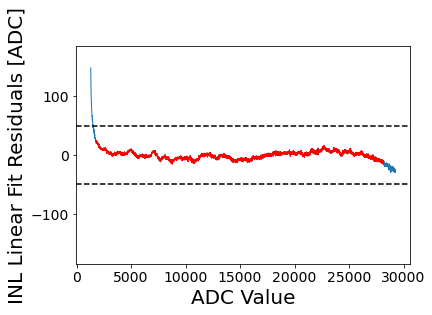

MeasuredMadDevLinFit 25.790976693858283
(5000,)
Fitting parameters for ADC Channel [86]
 
-0.1755 x + 5084


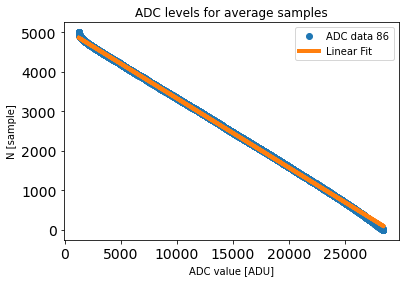

limits are [27437, 1663]


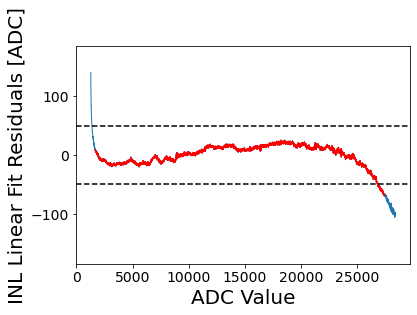

MeasuredMadDevLinFit 68.98517352601993
(5000,)
Fitting parameters for ADC Channel [87]
 
-0.1741 x + 5015


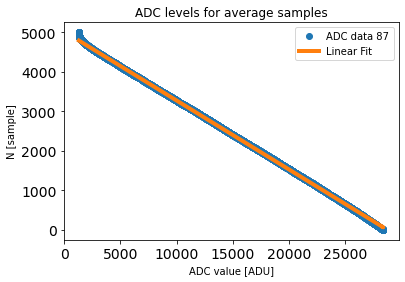

limits are [27411, 1519]


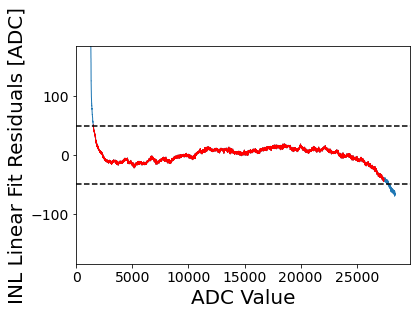

MeasuredMadDevLinFit 51.133866592100276
(5000,)
Fitting parameters for ADC Channel [88]
 
-0.175 x + 5088


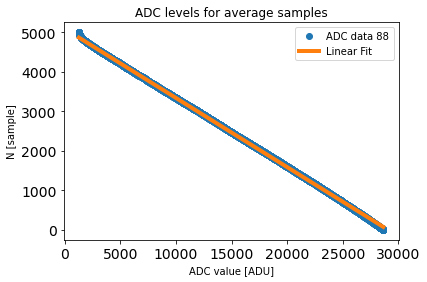

limits are [27672, 1746]


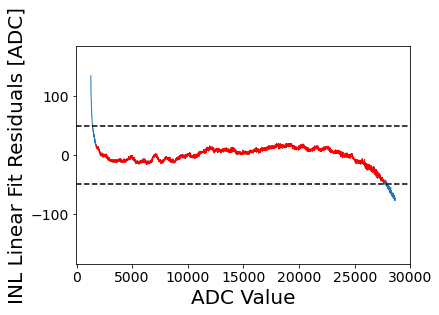

MeasuredMadDevLinFit 47.84143557034804
(5000,)
Fitting parameters for ADC Channel [89]
 
-0.175 x + 5089


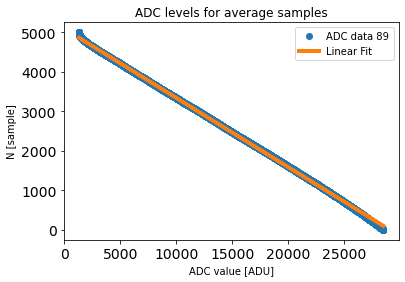

limits are [27550, 1732]


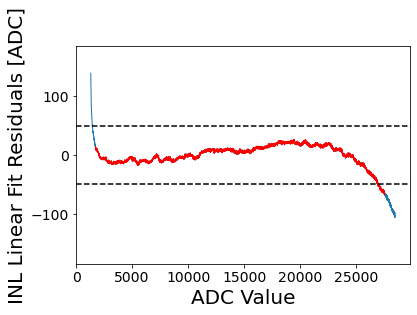

MeasuredMadDevLinFit 67.82876322108768
(5000,)
Fitting parameters for ADC Channel [90]
 
-0.174 x + 5072


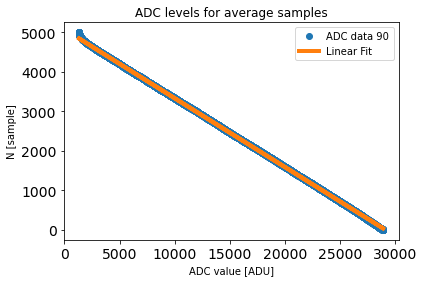

limits are [27860, 1704]


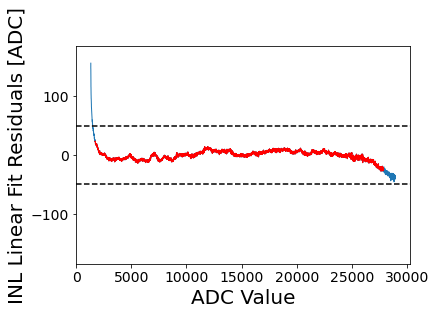

MeasuredMadDevLinFit 27.535564055287068
(5000,)
Fitting parameters for ADC Channel [91]
 
-0.1734 x + 5051


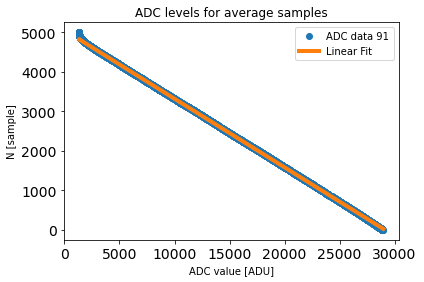

limits are [27879, 1635]


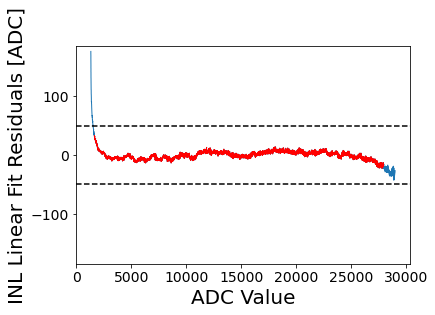

MeasuredMadDevLinFit 33.28156228210901
(5000,)
Fitting parameters for ADC Channel [92]
 
-0.1714 x + 5066


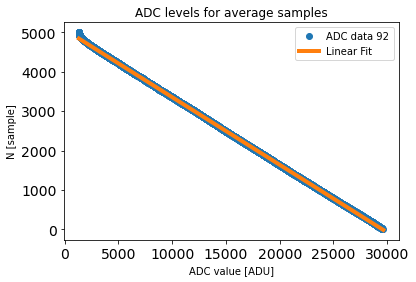

limits are [28493, 1753]


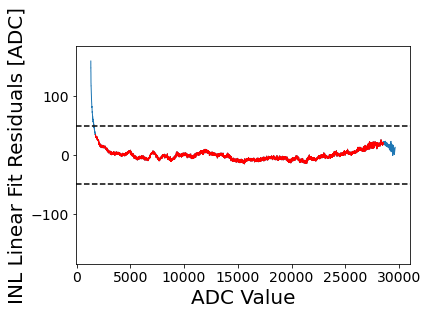

MeasuredMadDevLinFit 34.615254174648726
(5000,)
Fitting parameters for ADC Channel [93]
 
-0.1771 x + 5132


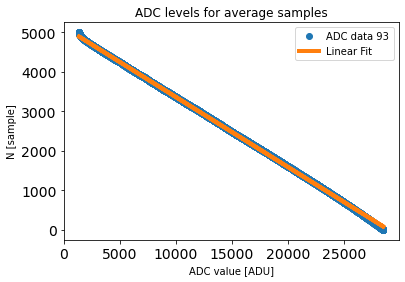

limits are [27575, 1899]


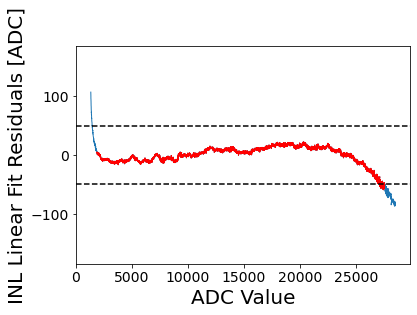

MeasuredMadDevLinFit 59.100230531976194
(5000,)
Fitting parameters for ADC Channel [94]
 
-0.1757 x + 5084


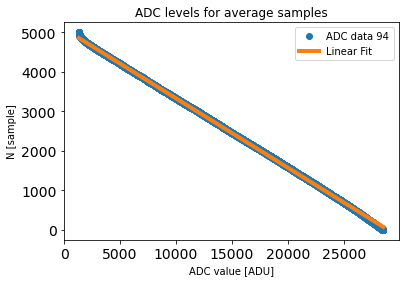

limits are [27498, 1723]


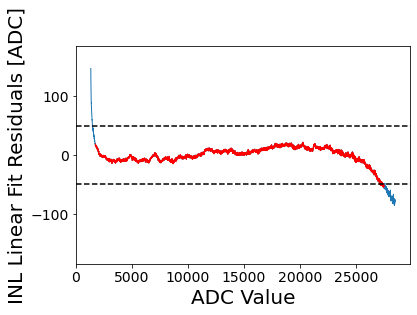

MeasuredMadDevLinFit 55.0277518930352
(5000,)
Fitting parameters for ADC Channel [95]
 
-0.1758 x + 5057


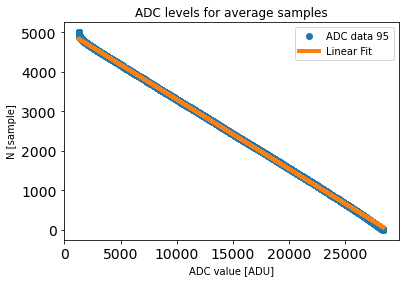

limits are [27401, 1609]


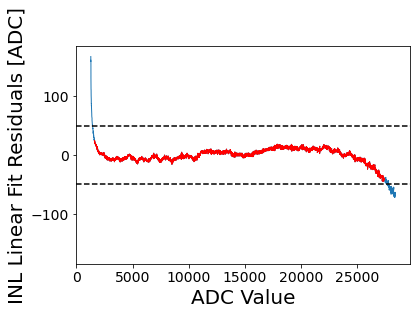

MeasuredMadDevLinFit 44.67169159388777


In [18]:
if ANALYSE_C:
    CHANNEL_INDEX_CTE = np.arange(192*0,192+192*0,16)
    BANK_C = 2
    CHANNEL_INDEX_CTE = np.arange(192*0+32*BANK_C,192*0+32*BANK_C+32,1)
    linearStartRange = int(15000/SCAN_STEP_C)
    linearEndRange = int(65000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    for column in CHANNEL_INDEX_CTE:
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        print(reducedDataSubset.shape)

        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        print("Fitting parameters for ADC Channel [%d]" %(column))
        print(f)

        x_est = x
        y_est = f(x_est)

        #plt.figure(1,figsize=(12,8),dpi=150)
        plt.title('ADC levels for average samples')
        plt.ylabel('N [sample]')
        plt.xlabel('ADC value [ADU]')
        plt.plot(x, y, 'o', x_est, y_est, linewidth=4)
        plt.legend([f'ADC data {column}', 'Linear Fit'])
        plt.show()

        x_diff = x
        y_diff = (y - y_est)

        print("limits are [%d, %d]" % (x_diff[startIndex],x_diff[stopIndex]))
        figureIndex += 0
        #plt.figure(1,figsize=(12,8),dpi=150)
        plt.rc('xtick', labelsize=14) 
        plt.rc('ytick', labelsize=14) 
        #plt.title('ADC level difference to linear fit')
        plt.ylabel('INL Linear Fit Residuals [ADC]', fontsize=20)
        plt.xlabel('ADC Value', fontsize=20)
        plt.plot(x_diff, y_diff, linewidth=1)
        plt.plot(x_diff[startIndex:stopIndex], y_diff[startIndex:stopIndex], 'r', linewidth=1)
        plt.ylim(-185,185)
        plt.axhline(50.0, color='black',linestyle='--') # cutoff frequency
        plt.axhline(-50.0, color='black',linestyle='--') # cutoff frequency
        #plt.savefig('cryoDiffLinearFit.png', dpi=300)
        #plt.savefig(os.path.splitext(filename)[0]+"corr_factor_"+ str(MID_SCALE_CORR_CTE) +"_channel_" + str(channelIndex) + "_figure_" + str(figureIndex) +".png")
        plt.show()

        MeasuredMadDevLinFit = np.max(np.abs(y_diff[startIndex:stopIndex]))
        print('MeasuredMadDevLinFit', MeasuredMadDevLinFit)

In [19]:
if ANALYSE_C:
    CHANNEL_INDEX_CTE = np.arange(192*0,192+192*0,1)
    #BANK_C = 0
    #CHANNEL_INDEX_CTE = np.arange(192+32*BANK_C,192+32*BANK_C+32,1)
    linearStartRange = int(15000/SCAN_STEP_C)
    linearEndRange = int(65000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    loopIndex = 0
    gainList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    measuredMaxDevLinFit = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    rangeList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    for column in CHANNEL_INDEX_CTE:
        
        rangeList[loopIndex] = np.max(imgDesc[linearStartRange:linearEndRange,row,column]) - np.min(imgDesc[linearStartRange:linearEndRange,row,column])
        
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        
        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        gainList[loopIndex] = f[1]
        
        x_est = x
        y_est = f(x_est)


        x_diff = x
        y_diff = (y - y_est)

               

        measuredMaxDevLinFit[loopIndex] = np.max(np.abs(y_diff[startIndex:stopIndex]))
                
        loopIndex +=1
        


[[ 0.00000000e+00 -1.74637607e-01  3.27494593e+01  2.74820000e+04]
 [ 1.00000000e+00 -1.74252227e-01  6.68409125e+01  2.69730000e+04]
 [ 2.00000000e+00 -1.70874484e-01  4.14713893e+01  2.78460000e+04]
 [ 3.00000000e+00 -1.73750039e-01  3.81878869e+01  2.79640000e+04]
 [ 4.00000000e+00 -1.72046608e-01  3.28155643e+01  2.81850000e+04]
 [ 5.00000000e+00 -1.74476555e-01  4.61054940e+01  2.72600000e+04]
 [ 6.00000000e+00 -1.75078415e-01  4.71577608e+01  2.71120000e+04]
 [ 7.00000000e+00 -1.72326327e-01  4.30633628e+01  2.82840000e+04]
 [ 8.00000000e+00 -1.73272594e-01  6.47716449e+01  2.70270000e+04]
 [ 9.00000000e+00 -1.74146417e-01  2.84388435e+01  2.76140000e+04]
 [ 1.00000000e+01 -1.74216045e-01  3.96222613e+01  2.76760000e+04]
 [ 1.10000000e+01 -1.76055178e-01  8.65874806e+01  2.68210000e+04]
 [ 1.20000000e+01 -1.76002264e-01  6.15923358e+01  2.70560000e+04]
 [ 1.30000000e+01 -1.72926235e-01  3.45648350e+01  2.76940000e+04]
 [ 1.40000000e+01 -1.74400873e-01  2.98645377e+01  2.75950000e

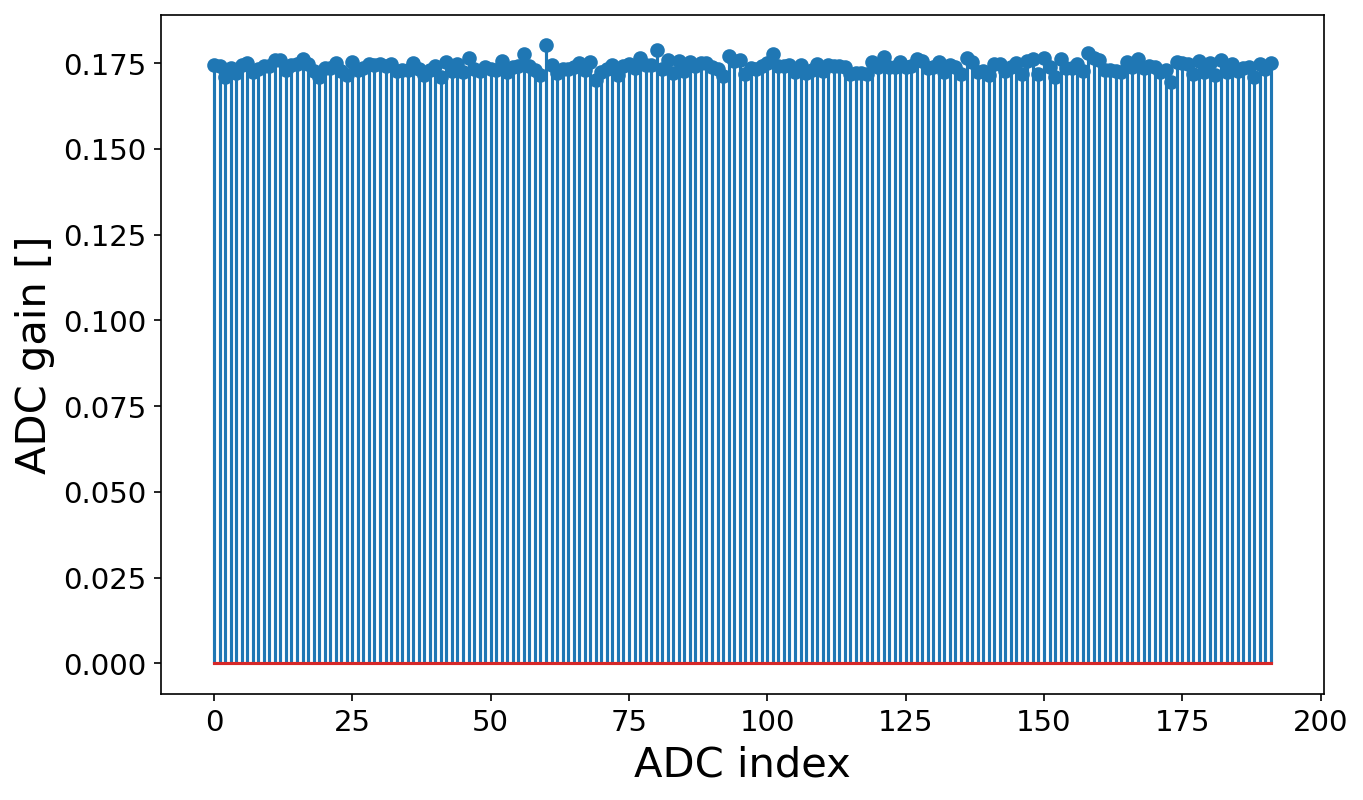

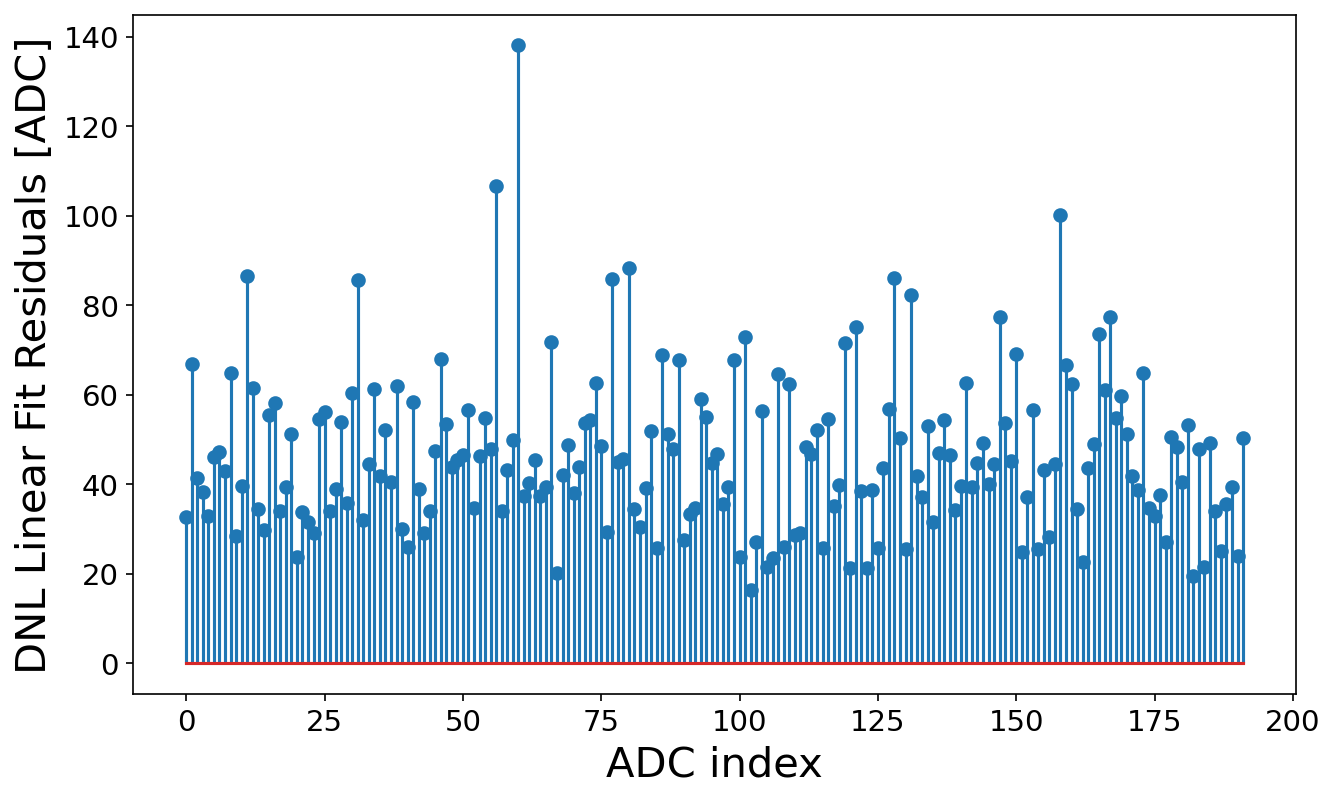

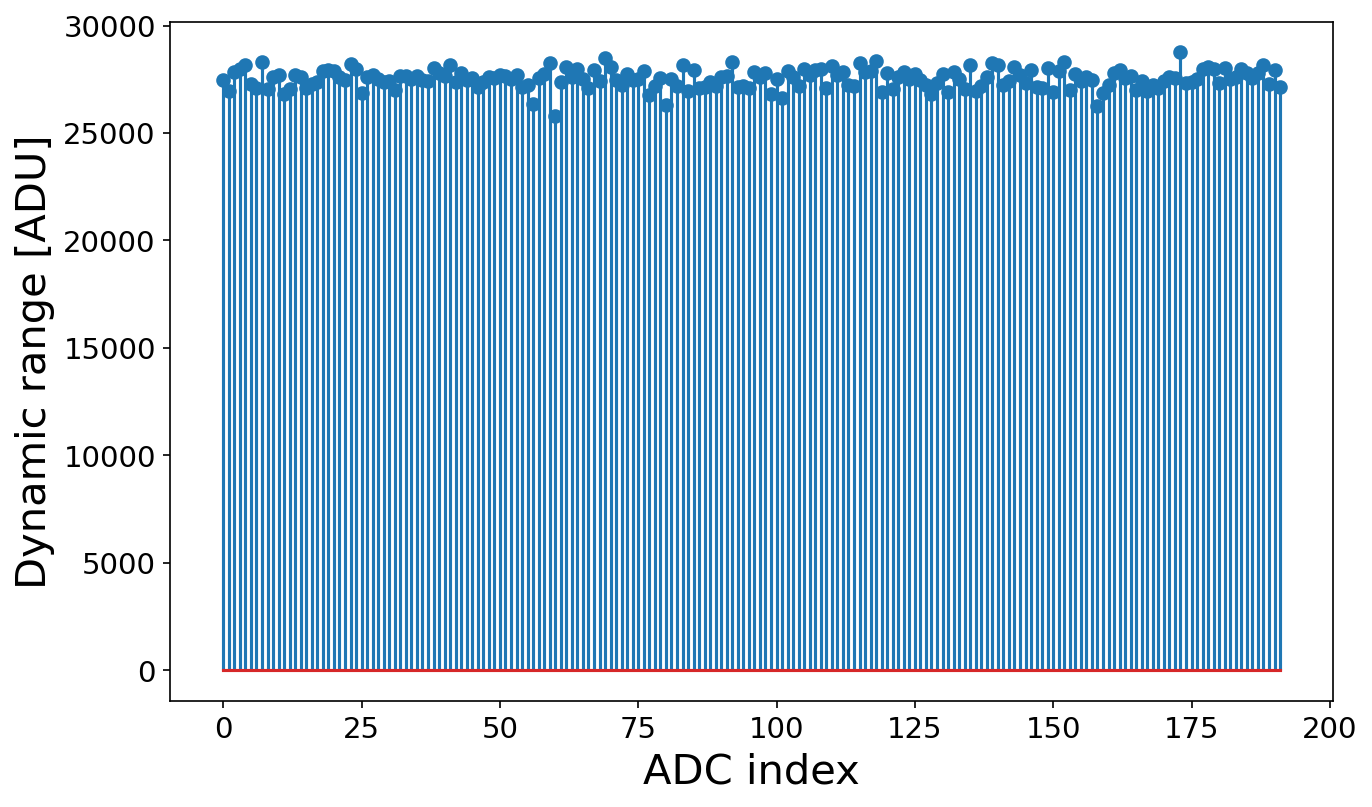

In [20]:
summary = []
summary.append(CHANNEL_INDEX_CTE)
summary.append(gainList)
summary.append(measuredMaxDevLinFit)
summary.append(rangeList)

summary_np = np.asarray(summary)
print(summary_np.transpose())

plt.figure(1,figsize=(10,6),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('ADC gain []', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(gainList))
plt.show()

plt.figure(1,figsize=(10,6),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('DNL Linear Fit Residuals [ADC]', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(measuredMaxDevLinFit))
plt.show()

plt.figure(1,figsize=(10,6),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('Dynamic range [ADU]', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(rangeList))
plt.show()

In [ ]:
whos